In [1]:
import os
import sys
import numpy as np
from PIL import Image, ImageFilter

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))  # dari notebooks ke project
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.crypto.keygen import generate_rsa_keys
from src.crypto.encrypt import rsa_encrypt
from src.stego.embed import embed_dwt
from src.stego.extract import extract_dwt
from src.utils.metrics import compute_psnr, compute_ssim

cover = os.path.join(PROJECT_ROOT, 'data', 'cover', 'cover1.jpg')
stego = os.path.join(PROJECT_ROOT, 'data', 'stego', 'robust.png')
private_key_path = os.path.join(PROJECT_ROOT, 'keys', 'private.pem')
public_key_path = os.path.join(PROJECT_ROOT, 'keys', 'public.pem')

# Debug: pastikan file cover ada
print("COVER EXISTS:", os.path.exists(cover))  # Harus True

# Generate RSA Keys, encrypt, embed
priv, pub = generate_rsa_keys(2048, private_key_path, public_key_path) # Generate RSA Keys
msg = b'Test robustness payload' # Encrypt pesan
ct = rsa_encrypt(msg, pub)
embed_dwt(cover, ct, stego) # Embed pesan terenkripsi ke dalam cover image
orig = np.array(Image.open(cover).convert('L'), dtype=np.uint8) # Load original image untuk perbandingan (grayscale)
stego_img = np.array(Image.open(stego).convert('L'), dtype=np.uint8) # Load stego image


COVER EXISTS: True


In [2]:
from PIL import Image
import numpy as np
import pywt
import io  # <--- tambahkan ini

def extract_dwt(stego_input, data_len: int, level: int = 1) -> bytes:
    """
    Extract binary data from a stego-image using DWT.
    `stego_input` can be a path (str) or a PIL.Image object.
    """
    if isinstance(stego_input, str):
        img = Image.open(stego_input).convert('L')
    else:
        img = stego_input.convert('L')  # PIL.Image.Image assumed

    arr = np.array(img, dtype=float)

    coeffs = pywt.wavedec2(arr, 'haar', level=level)
    cA, (cH, cV, cD) = coeffs[0], coeffs[1]

    flat = cD.flatten()
    bits = (flat > 0).astype(np.uint8)[:data_len * 8]
    byte_arr = np.packbits(bits)
    return byte_arr.tobytes()


tests = []
qualities = [90, 70, 50]
noises = [5, 10]

# JPEG compression
for q in qualities:
    buf = io.BytesIO()
    Image.open(stego).save(buf, format='JPEG', quality=q)
    buf.seek(0)
    img_jpeg = Image.open(buf)
    arr_jpeg = np.array(img_jpeg.convert('L'), dtype=np.uint8)
    ps = compute_psnr(orig, arr_jpeg)
    ss = compute_ssim(orig, arr_jpeg)
    extracted = extract_dwt(img_jpeg, len(ct))
    ber = np.mean(np.unpackbits(np.frombuffer(extracted, dtype=np.uint8)) !=
                  np.unpackbits(np.frombuffer(ct, dtype=np.uint8)))
    tests.append({'type':'JPEG', 'param':q, 'psnr':ps, 'ssim':ss, 'bit_error_rate':ber})

# Gaussian noise
for sigma in noises:
    img = Image.open(stego).convert('L')
    noise = np.random.normal(0, sigma, img.size[::-1]).reshape(img.size[::-1])
    arr_noisy = np.clip(np.array(img, float) + noise, 0, 255).astype(np.uint8)
    ps = compute_psnr(orig, arr_noisy)
    ss = compute_ssim(orig, arr_noisy)
    extracted = extract_dwt(Image.fromarray(arr_noisy), len(ct))
    ber = np.mean(np.unpackbits(np.frombuffer(extracted, dtype=np.uint8)) !=
                  np.unpackbits(np.frombuffer(ct, dtype=np.uint8)))
    tests.append({'type':'Noise', 'param':sigma, 'psnr':ps, 'ssim':ss, 'bit_error_rate':ber})


In [3]:
import pandas as pd

robust_df = pd.DataFrame(tests)
robust_df.to_csv('benchmarks/robustness.csv', index=False)
robust_df

,type,param,psnr,ssim,bit_error_rate
0,JPEG,90,57.132706,0.999282,0.509277
1,JPEG,70,48.977382,0.996698,0.510254
2,JPEG,50,46.536427,0.995270,0.510254
3,Noise,5,35.999218,0.852630,0.501465
4,Noise,10,30.294782,0.621614,0.479980


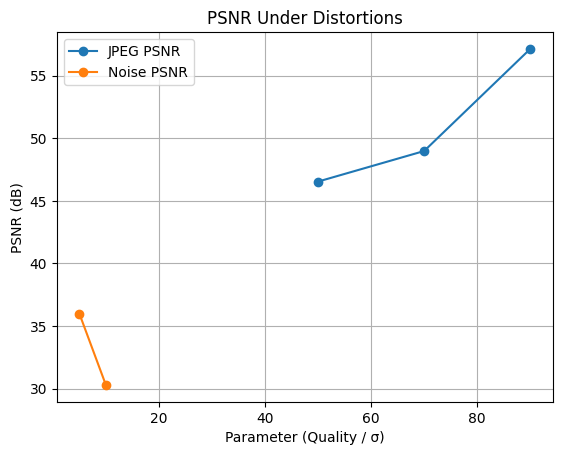

In [4]:
# Visualisasi PSNR under distortions
import matplotlib.pyplot as plt

for t in ['JPEG','Noise']:
    sub = robust_df[robust_df['type']==t]
    plt.plot(sub['param'], sub['psnr'], marker='o', label=f'{t} PSNR')
plt.title('PSNR Under Distortions')
plt.xlabel('Parameter (Quality / σ)')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.grid(True)
plt.show()